### Loading Libraries

In [24]:
import pandas as pd
import numpy as np
from luminol.anomaly_detector import AnomalyDetector
from luminol.correlator import Correlator
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt

### Loading Data

In [25]:
data = pd.read_table('C:\\Users\\Prajwal\\Desktop\\RefrigerationDevices_TEST', header=None, index_col=False,delimiter=',')
data = data.transpose()
class1 = data.ix[:,data.ix[0] == 1]
class1.head()

,0,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.0000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
1,1.0634,-0.95341,1.09040,-0.84982,-0.90531,-1.34960,-1.07870,1.06240,-0.76281,0.44646,...,1.2709,1.73890,1.55630,-0.64836,0.97143,0.57034,0.47632,0.81162,0.58858,0.77744
2,1.0634,-0.87025,0.77728,-0.84982,-0.43298,0.72227,0.85813,-0.93999,1.18480,0.70738,...,1.2709,1.73890,1.55630,-0.64836,1.80500,0.57034,0.78852,0.81162,0.58858,1.04480
3,1.0634,0.62656,1.09040,-0.92679,1.14150,0.72227,0.85813,1.06240,-0.76281,0.44646,...,1.2709,0.40909,1.27800,-0.64836,1.52710,0.57034,0.47632,0.81162,0.58858,0.77744
4,1.0634,2.20650,1.09040,-0.84982,1.14150,-1.34960,-1.07870,-0.93999,1.18480,0.44646,...,1.2709,-0.62518,-0.53101,-0.64836,1.52710,0.57034,0.78852,0.50943,0.58858,0.77744


### Extracting three Time Series data and converting them to required format

In [26]:
ts1 = np.asarray(class1.ix[1:,3])
ts2 = np.asarray(class1.ix[1:,2])
ts3 = np.asarray(class1.ix[1:,1])
tsd1 = dict(enumerate(ts1.flatten(), 1))
tsd2 = dict(enumerate(ts2.flatten(), 1))
tsd3 = dict(enumerate(ts1.flatten(), 1))

### Visualizing data

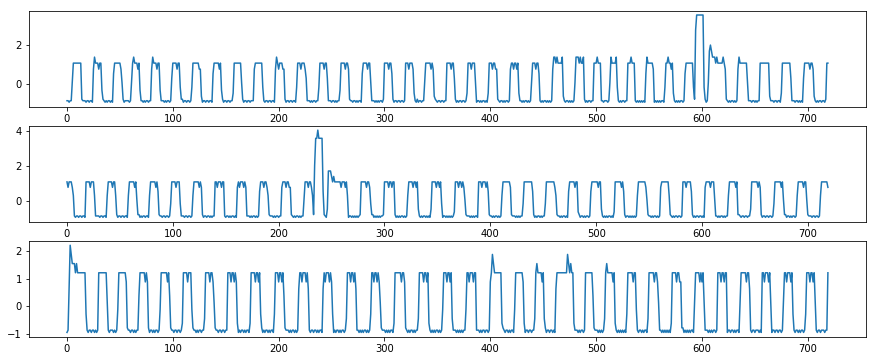

In [27]:
fig = plt.figure(figsize=(15,6))
plt.subplot(311)
plt.plot(ts1)
plt.subplot(312)
plt.plot(ts2)
plt.subplot(313)
plt.plot(ts3)

### Using LinkedIn Anomaly Detector to calculate anomaly scores

In [30]:
from luminol.anomaly_detector import AnomalyDetector
my_detector = AnomalyDetector(tsd1,algorithm_name='exp_avg_detector')
score = my_detector.get_all_scores()
sc=[]
for timestamp, value in score.iteritems():
    x=(timestamp, value)
    sc.append(x)
scrs=np.asarray(sc)
scores=pd.DataFrame(data=scrs, columns=('time', 'anomaly_score'))
scores.head(10)

,time,anomaly_score
0,1.0,0.000000
1,2.0,0.000000
2,3.0,0.061620
3,4.0,0.012324
4,5.0,0.009859
5,6.0,0.747366
6,7.0,1.398961
7,8.0,1.119168
8,9.0,0.895335
9,10.0,0.716268


### Sorting the scores in Descending order

In [31]:
sscrs = scrs[scrs[:,1].argsort()]
desc_sc=sscrs[::-1]
descending_scores = pd.DataFrame(data=desc_sc,columns=('time', 'anomaly_score'))
descending_scores.head(10)

,time,anomaly_score
0,603.0,2.497097
1,604.0,2.490659
2,596.0,2.197248
3,605.0,2.115774
4,595.0,1.976314
5,597.0,1.757798
6,606.0,1.631000
7,482.0,1.553560
8,624.0,1.487941
9,461.0,1.483971


### Plotting top 10 anomalies

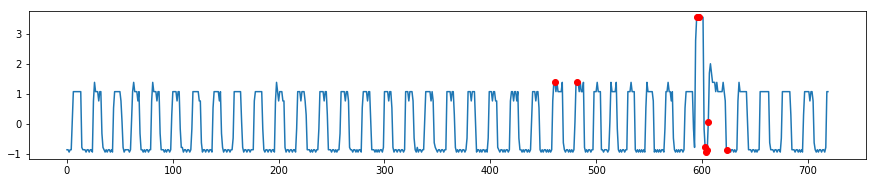

In [32]:
inds=desc_sc[:10,0].astype(int)
vals=np.take(ts1, inds)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts1, label='Data')
plt.plot(inds, vals,'ro', label='warning')

### Correaltion between two time series

In [33]:
from luminol.correlator import Correlator
k=0
ccs=[]
tsts=[]
window=30
for i in range(24):
    tstamp=(k,k+window)
    tsts.append(tstamp)
    my_correlator = Correlator(tsd1, tsd2, time_period=tstamp)
    res=my_correlator.get_correlation_result()
    ccs.append(res.coefficient)
    k=k+window

tstamps=np.array(tsts)
coeffs=np.reshape(np.array(ccs), (len(ccs),1))

correlation_result=np.concatenate((tstamps,coeffs), axis=1)
correlation_result = correlation_result[correlation_result[:,2].argsort()]
result=pd.DataFrame(data=correlation_result, columns=('start_time', 'end_time', 'correlation_index'))
result.head(10)

,start_time,end_time,correlation_index
0,240.0,270.0,0.328009
1,600.0,630.0,0.446845
2,210.0,240.0,0.461591
3,510.0,540.0,0.521173
4,480.0,510.0,0.522976
5,570.0,600.0,0.537776
6,390.0,420.0,0.596234
7,540.0,570.0,0.597192
8,420.0,450.0,0.653765
9,360.0,390.0,0.665195


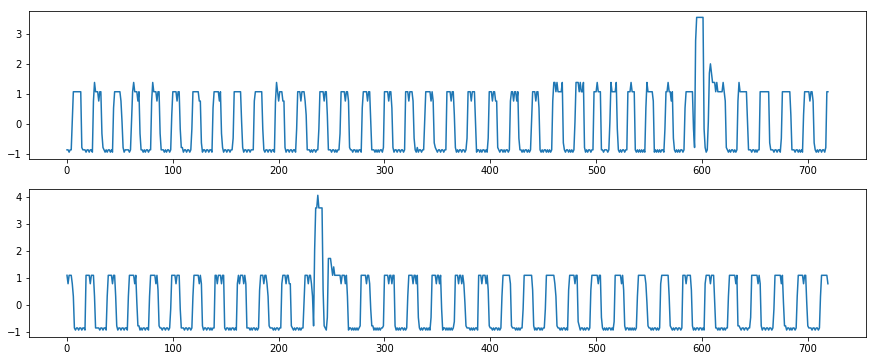

In [34]:
fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts1)
plt.subplot(212)
plt.plot(ts2)

### Distance between two time series using Dyanamic time Warping

#### In time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences which may vary in time or speed.

In [21]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
distance, path = fastdtw(ts1,ts2, radius=1, dist=euclidean)
print(distance)

268.3834229999987
